In [1]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px


In [2]:
data_path = "data/"

df_train = pd.read_csv(data_path + "df_imputed_train.csv")
df_test = pd.read_csv(data_path + "df_imputed_test.csv")
#data is already normalized

df_train.drop(columns=['DELIVERY_START'], inplace=True)
df_test.drop(columns=['DELIVERY_START'], inplace=True)

In [3]:
pca = PCA(n_components=0.95, random_state=42)
pca.fit(df_train)
df_train_pca = pca.transform(df_train)

In [4]:
# 3. Try different numbers of clusters and compute BIC or silhouette
bic_scores = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_train_pca)
    labels = gmm.predict(df_train_pca)
    
    bic_scores.append(gmm.bic(df_train_pca))
    silhouette_scores.append(silhouette_score(df_train_pca, labels))

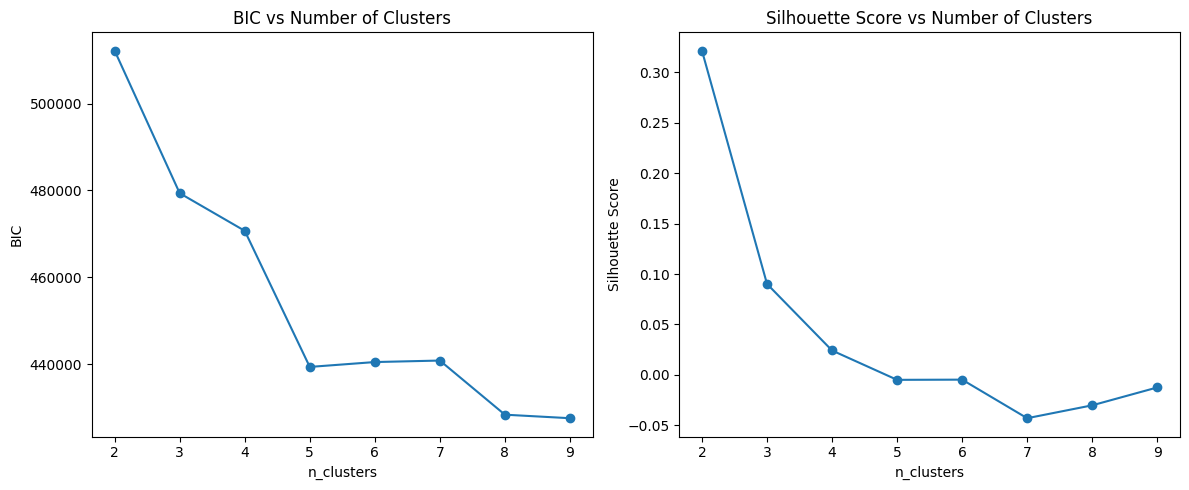

'\nBIC Score\nBIC decreases sharply from 2 to 5 clusters, then flattens out.\n\nElbow appears around 5: beyond that, BIC improvement is marginal.\n\nThis suggests that 5 clusters could be a good fit without overfitting.\n\nSilhouette Score\nBest score is at 2 clusters (~0.32), but:\n\nIt drops quickly afterward and stays very low.\n\nScores < 0.1 suggest poorly separated or overlapping clusters, which can happen in high-dim or continuous utility data.\n'

In [5]:
#Plot to help choose optimal K
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(k_range, bic_scores, marker='o')
plt.title("BIC vs Number of Clusters")
plt.xlabel("n_clusters")
plt.ylabel("BIC")

plt.subplot(1,2,2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

#Interpretation of the results
# The BIC score is a measure of model fit, with lower values indicating a better fit.
# The silhouette score measures how similar an object is to its own cluster compared to other clusters.
# A higher silhouette score indicates better-defined clusters.
"""
BIC Score
BIC decreases sharply from 2 to 5 clusters, then flattens out.

Elbow appears around 5: beyond that, BIC improvement is marginal.

This suggests that 5 clusters could be a good fit without overfitting.

Silhouette Score
Best score is at 2 clusters (~0.32), but:

It drops quickly afterward and stays very low.

Scores < 0.1 suggest poorly separated or overlapping clusters, which can happen in high-dim or continuous utility data.
"""

#In our case, let's choose 5 clusters based on BIC and interpret the results.

Text(0.5, 1.0, 'Cluster Distribution')

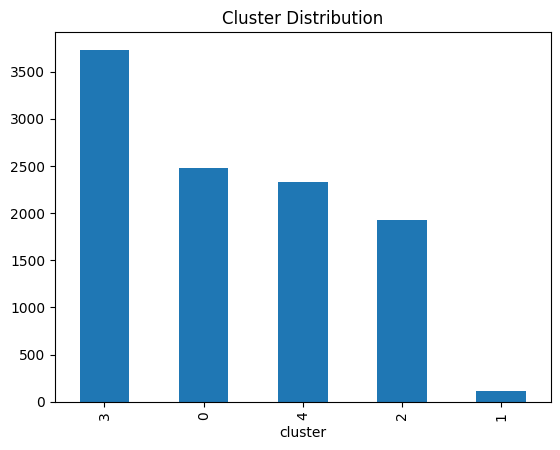

In [6]:
# Fit GMM with 5 clusters and visualize the results

gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(df_train_pca)
labels = gmm.predict(df_train_pca)
df_train['cluster'] = labels
df_train['cluster'].value_counts().plot(kind='bar')
plt.title("Cluster Distribution")

In [7]:
# Let's visualize the clusters in 2D using PCA
pca_3d = PCA(n_components=3, random_state=42)
pca_3d.fit(df_train)
df_train_3d = pca_3d.transform(df_train)

fig = px.scatter_3d(
    x=df_train_3d[:, 0],
    y=df_train_3d[:, 1],
    z=df_train_3d[:, 2],
    color=labels,  # You can replace `labels` with any other column or array for coloring
    title="3D PCA of Clusters",
    labels={'x': 'PCA1', 'y': 'PCA2', 'z': 'PCA3'},
    color_discrete_sequence=px.colors.qualitative.Plotly,  # You can replace this with a different color sequence
    opacity=0.7,
)
fig.update_traces(marker=dict(size=3))  # Decrease the size of the points
fig.show()

# A not so good clustering result, but we can try to interpret the clusters anyway.
# Let's check the means of each cluster in the original space

# Add cluster labels to original dataset
df_clustered = pd.DataFrame(df_train, columns=df_train.columns)  # replace with your actual feature names
df_clustered["cluster"] = labels

# Get cluster sizes
cluster_sizes = df_clustered["cluster"].value_counts().sort_index()
print("Cluster sizes:")
print(cluster_sizes)

# Calculate mean (or median) feature values per cluster
cluster_profiles = df_clustered.groupby("cluster").mean()  # or .median()
cluster_profiles_rounded = cluster_profiles.round(2)
cluster_summary = cluster_profiles_rounded.T

Cluster sizes:
cluster
0    2483
1     120
2    1924
3    3730
4    2330
Name: count, dtype: int64
